# Regression

So far our target has always been of categorical type. However, it is very likely that one encounters situations where the target is continuous like for example the example with boat lengths - or actually even with the previous example of income. We shall limit ourselves where the target is single value though there is no inherent reason why this would be the case. That is, we try to predict using item $\mathbf{x}$ the target value $y \in \mathbb{R}$. Since most have already been in courses of statistics you guessed it - we shall be first doing linear regression, but soon present tree regreesor and random forest regressors as well.
***
#### What:
1. Linear regression.
2. How to find the parameters in linear regression?
3. Regression fit goodness estimate - RMS loss.
4. Gradient descent...? Some minimization anyway...
5. Tree regressor and RF regressors.
6. Examples of applying regressors - predicting.
***
#### Def 1. A computer program is said to learn from *experience* **E** with respect to some class of *tasks* **T** and *performance measure* **P**, if its performance at tasks in **T** as measured by **P**, improves with experience **E**. 

-Mitchell, T. (1997). Machine Learning.

In [1]:
# Import the required libraries
import pandas as pd # Pandas deals with handling data. 
import numpy as np # Numpy provides a lot of FAST ways for array manipulation in python.
import matplotlib.pyplot as plt # Plotting script library
import matplotlib as mpl # Plotting
import seaborn as sns # More plotting

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".99"})
sns.set_style("ticks")

data = sns.load_dataset('penguins').dropna()
target = 'species'
xlabel = 'bill_length_mm'
ylabel = 'bill_depth_mm'

### Training supervised regressor using scikit-learn:

Let us start by just applying the linear regressor ([LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) from sklearn to predict the mass of a penguin given the species (Gentoo) and some features like, 'bill_length_mm' and/or 'bill_depth_mm'. Recall Linear models:

$
y = \mathbf{w} \cdot \mathbf{x} + b, 
$

where $\mathbf{w} = [w_1,\dots,w_{\text{dim}(\mathbf{x})}]$ and $b$ are the parameters of the linear model (affine since there is bias).

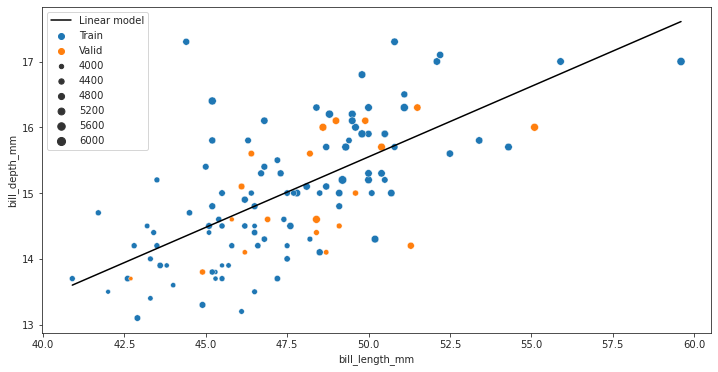

In [2]:
from sklearn.model_selection import train_test_split

# select only single species from the data
species = 'Gentoo'
mask = data.species == species
data_gentoo = data[mask]

# Select only species
X = data_gentoo.loc[:, xlabel].values.reshape(-1, 1)
y = data_gentoo.loc[:, ylabel].values

# Pick the validation set randomly:
valid_idx = np.random.choice(len(X), size=20, replace=False)

# Train valid mask:
trainvalid = np.zeros(len(X), dtype=bool)
trainvalid[valid_idx] = True

# Import the linear regression model
from sklearn.linear_model import LinearRegression


# We fit the linear model to training data:
linreg = LinearRegression().fit(X[~trainvalid, :], y[~trainvalid])

ax = sns.scatterplot(data=data_gentoo, 
                     x=xlabel, 
                     y=ylabel, 
                     hue=[{0:'Train', 1:'Valid'}[tr] for tr in trainvalid], 
                     palette={'Train':'C0', 'Valid':'C1'},
                     size='body_mass_g')

xmin = data_gentoo.loc[:, xlabel].min()
xmax = data_gentoo.loc[:, xlabel].max()

xrange = np.linspace(xmin, xmax, 20)
ax.plot(xrange, linreg.coef_[0]*xrange + linreg.intercept_, color='black', label='Linear model')

_ = plt.legend()

### Discussion:

In statistics it is not common (?) to use 'valid sets' to estimate the goodness of a model  fit (here model = linear regression) - why do we do it now? The reason is that statisticians make (analytical) models - they have (hopefully) well grounded reasons to believe that their model ought to work, or they are in a process of testing if it works. They understand the risks of having a lot of free parameters and implement serious protections to not fool themselves:

#### The first principle is that you must not fool yourself — and you are the easiest person to fool.

-Richard Feynmann

If a test statistic measuring the goodness of a fit in their dataset tells that it indeed seems to explain the data they are happy - they have managed to produce understanding (in form of mathematical model) and the phenomena under consideration is 'explained'. On the other hand in ML you do not often seek to produce understanding of the process generating the data you work with, after all if you did why would you use a 'black box' ML methods in the first place as they will be difficult to interpret in the end and you return to square one? What you are seeking after are *predictions* about unseen data items that you ought to receive and on the goodness of those prediction. Hence, you also are not certain that even if you manage to fit you model into your *training data* it does not necessarily mean that it works in the *real world*. You see statistician actually understood what is going on and thus also know where to apply the model and where not - you do not possess such a luxury, the only way to make sanity checks about your ML model is to test it in validation data. 

Indeed, what separates ML from regular phenomenological modeling is that most of the time you do not care to *understand* the system or the system is so complicated that it is completely impossible to find reasonable models (consider for example image recognition). However, it is not too rare that a given ML task can be solved by simple methods with the added benefit that usually those methods are also easier (or at least possible) to interpret [see](https://community.fico.com/s/blog-post/a5Q2E0000001czyUAA/fico1670).

An important thing to note is that sampling the validation/test sets is not always as straightforward as here. When picking the validation and test sets think taht they ought to represent the data you are going to encounter in the runtime, try not to foll yourselve. 

All this is kind of hard to see from the above example after all there is no much room for ML in the above example, but let us show what might happen if you get a bit carried away with you linear regression and only consider the goodness of the fin in the training data.
***
### If you are not careful this can happen:

We take the same dataset as before, but 'augment' it to also include powers of the xlabel to obtain better fits in the training data:

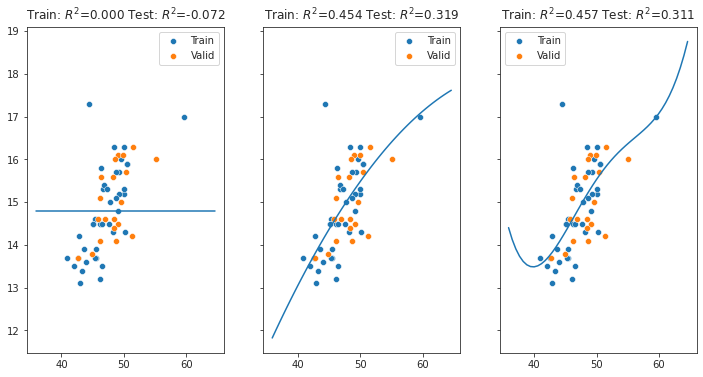

In [25]:
from sklearn.preprocessing import PolynomialFeatures


_, axarr = plt.subplots(1, 3, sharex=True, sharey=True)
X_train = X[trainvalid==0][:40]
X_valid = X[trainvalid==1]
y_train = y[trainvalid==0][:40]
y_valid = y[trainvalid==1]


for degree, ax in zip(range(0,10, 2), axarr.flatten()):
    poly = PolynomialFeatures(degree=degree)
    
    X_train_aug = poly.fit_transform(X_train)
    linreg.fit(X_train_aug, y_train)
    
    sns.scatterplot(x=X_train.flatten(), y=y_train, ax=ax, label='Train')
    sns.scatterplot(x=X_valid.flatten(), y=y_valid, ax=ax, label='Valid')
    
    
    X_valid_aug = poly.transform(X_valid)
    xrange = np.linspace(xmin-5, xmax+5, 50).reshape(-1, 1)
    
    X_plot = poly.transform(xrange)
    y_pred = linreg.predict(X_plot)
    
    ax.plot(xrange, y_pred, label='Fit, degree={}'.format(degree))
    
    # Notice that linreg carries its own score function with it:
    R2_train = linreg.score(X_train_aug, y_train)
    R2_valid = linreg.score(X_valid_aug, y_valid)
    
    ax.set_title(r'Train: $R^2$={:.3f} Test: $R^2$={:.3f}'.format(R2_train, R2_valid))
    

In the above, which of the models overfitted and which underfitted? Notice also, that the sole reason for us being able to see that the model on the right and left are bad (apart from the $R^2$ scores) is that we plot the fit and the data - in reality there are dozens if not hundreds of dimensions, there is no hope for one to be able to visually inspect if the ML model fit is reasonable or not.

The thing is with dozens, hundreds or millions (neural networks) of free parameters in a flexible enough model you are basically able to capture whatever you aim (for example those pet breeds). Part of the challenge is not to capture *only* the thing you present but also *generalize* well outside the training data.

### An important note about free parameters:

#### "With four free parameters I can fit an elephant, and with five I can make it wiggle its trunk" 

-John von Neumann

And that is not to say that free parameters are cool and great thing (at least outside ML)... The validation set is for us to figure out the right number of parameters to build the ml model.
***

## Finding parameters:

What we are basically left to do is to understnd how the LinearRegressor can find the coefficients ($\omega$) it uses. If we can understand that we are more or less done in the business of ML including the neural networks (at least conceptually ;)). We are actually pretty close since we already in the above had the $R^2$ score as an estimate for the goodness of the LinReg model fit. Obviously the task is to find parameters $\mathbf{w}$ so that the $R^2$ score is maximized - let us do exactly that:

In [8]:
def get_grad(func, w, dw, *args):
    """
    How does the value of func change when we modify each component of 
    w by dw:
    
    Never implement this kind of (mathematical) functions yourself unless for 
    demonstration purposes only. They exist in libraries are are 
    done way better there!
    """
    ngrad = np.zeros(len(w))
    for i in range(len(w)):
        wdw = w.copy()
        wdw[i] += dw
        ngrad[i] = (func(wdw, *args) - func(w, *args))/dw
        
    return ngrad

In [26]:
func = lambda x: x**2
lr = .05
x = np.array([1.])
dx = .00001
N = 50
progress = np.zeros((N, 4))

for i in range(N):
    
    grad = get_grad(func, np.array([x]), dx)
    
    # Step in x is the grad * learning rate
    stepx = grad*lr
    # The anticipated step in y is, however, this is only approximation.
    stepy = grad*stepx
    
    progress[i,:] = x, func(x), stepx, stepy
    
    x -= lr*grad
    
animate_descent(progress, func, np.linspace(-.2, 1, 20))     

## Lets then apply this machinery to find the linreg coefficients:

In [23]:
def set_linreg_params(linreg, w):
    # Set the coefficients:
    linreg.coef_ = w[:-1]
    # Set the intercept
    linreg.intercept_ = w[-1]
    
    return linreg

def get_R2(w, X, y, linreg):
    """
    Get the R^2 score of the lin regressor.
    """    
    linreg = set_linreg_params(linreg, w)
    
    return linreg.score(X, y)

w = np.array([0.0, 0.0], dtype=float)
lr = .00001 #.0001
dw = .000001

N = 100
wprogress = np.zeros((N, 3))
for i in range(N):
    wg = get_grad(get_R2, w, dw, X_train, y_train, linreg)
    w += wg*lr
    
    linreg = set_linreg_params(linreg, w)
    wprogress[i, :] = *w, linreg.score(X_train, y_train)
    
animate_linreg(wprogress, X_train, y_train)  

#### Questions:
1. Say you had a time series data where you would be interersted in some quantity in the future, how would you then pick the training and validation sets? 


In [22]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc

rc('animation', html='jshtml') #, html='html5')

def animate_descent(progress, fun, xrange):
    
    fig, ax = plt.subplots()
    
    # Lines to plot
    dx, = ax.plot([], [], '-', color='C0', lw=2)
    dy, = ax.plot([], [], '-', color='C0', lw=2)
    
    
    scat = ax.scatter([], [], label='steps')
    
    def init():
        
        # Init the axeses:
        ax.plot(xrange, fun(xrange), color='C1', label='Fun')
        
        return dx, dy, scat, 

    def update(frame):
        
        
        x, y, dx_, dy_ = progress[frame, :]
        
        # Update the line points
        dx.set_data([x, x-dx_], [y, y])
        dy.set_data([x-dx_, x-dx_], [y, y-dy_])
        
        X = np.c_[progress[:frame+1, 0], progress[:frame+1, 1]]
        scat.set_offsets(X)
        #scat.set_offsets(progress[:frame, 0], progress[:frame, 1])
        
        
        return dx, dy, scat, 

    ani = FuncAnimation(fig, update, 
                        frames=np.arange(len(progress)), 
                        interval=int(10000/len(progress)),
                        init_func=init, blit=True)
    
    plt.close() # Remove the otherwise annoying extra plot..
    return HTML(ani.to_jshtml())

def animate_linreg(w, X_train, y_train):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    # Lines to plot
    ln_pred, = ax1.plot([], [], '-', color='C0', lw=1, label='Estim')
    ln_params, = ax2.plot([], [], '-o', color='C0', lw=1, label='Score')
    ln_score, = ax3.plot([], [], '-o', color='C0', lw=1, label='Score')
    
    
    x = X_train.flatten()
    ax1.scatter(x, y_train, label='Train instances', c='C0')
    hist = 5
    
    
    
    def init():
        
        # Init the axeses:
        
        ax1.legend()
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.set_title('Dataa and fit:')
        
        ax3.legend()
        ax3.set_xlim([0, len(w)])
        ax3.set_ylim([-1, 1.1*w[:, 2].max()])
        ax3.set_xlabel('N steps')
        ax3.set_ylabel(r'R^2 score')
        ax3.set_title('R^2 Score')
        #ax3.semilogy()
        
        ax2.set_xlim([w[:, 0].min(), w[:, 0].max()])
        ax2.set_ylim([w[:, 1].min(), w[:, 1].max()])
        ax2.set_xlabel('w')
        ax2.set_ylabel('Intercept')
        ax2.set_title('LinReg params')
        
        return ln_pred, ln_score, ln_params,  

    def update(frame):
        
        a = w[frame, 0]
        b = w[frame, 1]
        
        # Update the line points
        ln_pred.set_data(x, a*x + b)
        ln_score.set_data(range(frame+1), w[:(frame+1), 2])
        ln_params.set_data(w[:frame, 0], w[:frame, 1])
        
        #if frame > hist:
        #    # Update the limits:
        #    ax2.set_xlim([w[frame-5:frame, 0].min(), w[frame-5:frame, 0].max()])
        #    ax2.set_ylim([w[frame-5:frame, 1].min(), w[frame-5:frame, 1].max()])
        #    ax3.set_xlim([frame-hist, frame])
        #    ax3.set_ylim([w[frame-hist:frame, 2].min(), w[frame-hist:frame, 2].max()])
        
        
        return ln_pred, ln_score, ln_params, 

    ani = FuncAnimation(fig, update, 
                        frames=np.arange(len(w)), 
                        interval=int(10000/len(w)),
                        init_func=init, blit=True)
    
    plt.close() # Remove the otherwise annoying extra plot..
    return HTML(ani.to_jshtml())